- Ajustad un modelo de Decision Tree a nuestros datos.

- Calculad las métricas a nuestro nuevo modelo.

- Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_esta = pd.read_csv("./Datos/tiempo_esta_cod.csv", index_col = 0)
df_esta.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather_Mainly Clear,hora_1,hora_2,hora_3,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,-0.755162,-0.366931,1.320679,-0.201398,-1.722126,-1.782197,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.645784,-0.430150,0.616199,2.334455,-0.673565,0.024563,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.662611,-0.484338,0.488112,2.467921,-0.673565,0.024563,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.729921,-0.556589,0.488112,2.334455,-0.673565,0.024563,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.755162,-0.556589,0.552155,2.334455,-0.673565,0.024563,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separamos los datos en X e y

X1 = df_esta.drop("Weather_Mainly Clear", axis = 1)
y1 = df_esta["Weather_Mainly Clear"]

In [5]:
# separamos en train y test
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)


DecisionTreeClassifier(random_state=0)

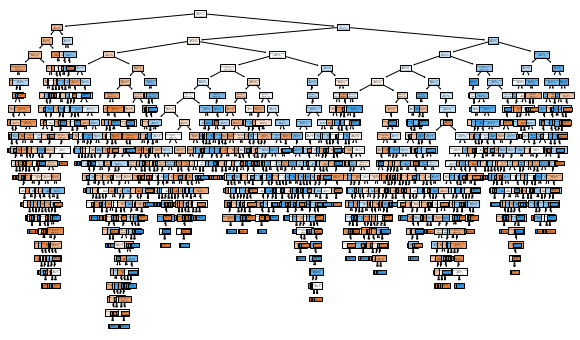

In [7]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
plt.show()

In [8]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train1.columns))
max_features

4.69041575982343

In [9]:
# max depth

print(arbol.tree_.max_depth)

23


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [11]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [12]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results1

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.638323,0.621176,0.651852,0.636145,0.277036,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I


In [13]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [14]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla


In [15]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [16]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=14, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

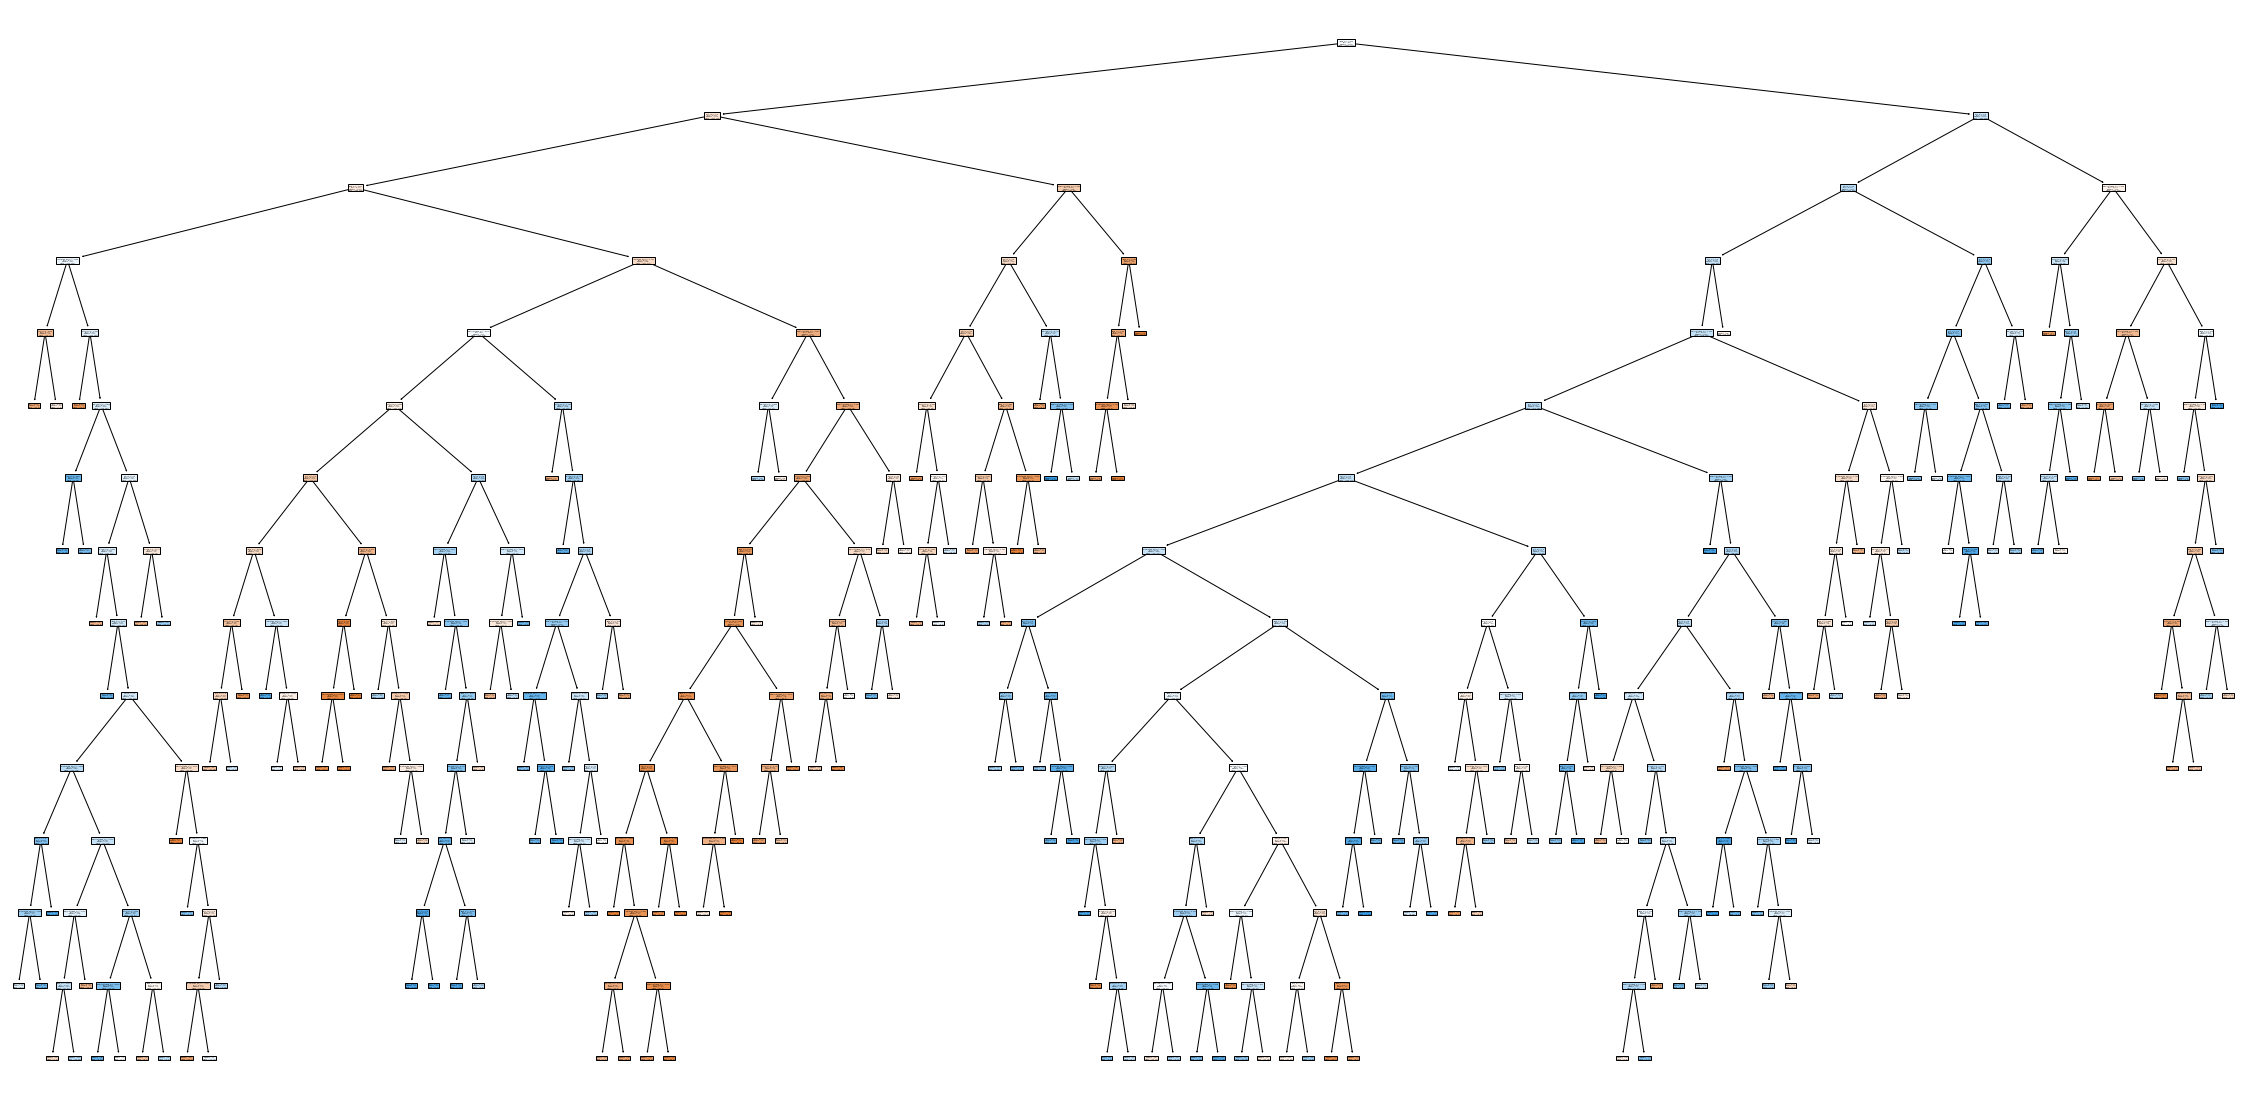

In [17]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [18]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [19]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision tree Esta II")
dt_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.578443,0.563549,0.580247,0.571776,0.156856,test,Decision tree Esta II
1,0.717964,0.724956,0.718989,0.721960,0.435822,train,Decision tree Esta II


In [20]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.638323,0.621176,0.651852,0.636145,0.277036,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.578443,0.563549,0.580247,0.571776,0.156856,test,Decision tree Esta II
1,0.717964,0.724956,0.718989,0.721960,0.435822,train,Decision tree Esta II


In [23]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo
# vamos a cargar ese csv para comparar todos los modelos que hemos hecho, y comparar cuál de ellos es el mejor

df_regresion_results = pd.read_csv("./Datos/resultados_regresion.csv", index_col = 0)
df_regresion_results


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.485030,0.485030,1.000000,0.653226,0.000000,test,Regresión logistica
1,0.608383,0.611838,0.631981,0.621747,0.216008,train,Regresión logistica
0,0.600000,0.579418,0.639506,0.607981,0.201689,test,Regresión logistica Esta
1,0.610479,0.612233,0.641387,0.626471,0.219987,train,Regresión logistica Esta
